In [13]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

import itertools  # Import this at the top of your script

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

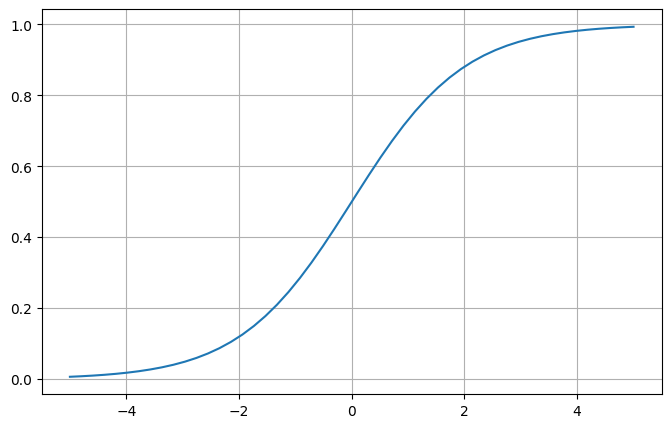

In [14]:
# Sigmoid function in Python
x = np.linspace(-5, 5, 50)
z = 1/(1 + np.exp(-x))

plt.subplots(figsize=(8, 5))
plt.plot(x, z)
plt.grid()
plt.show()

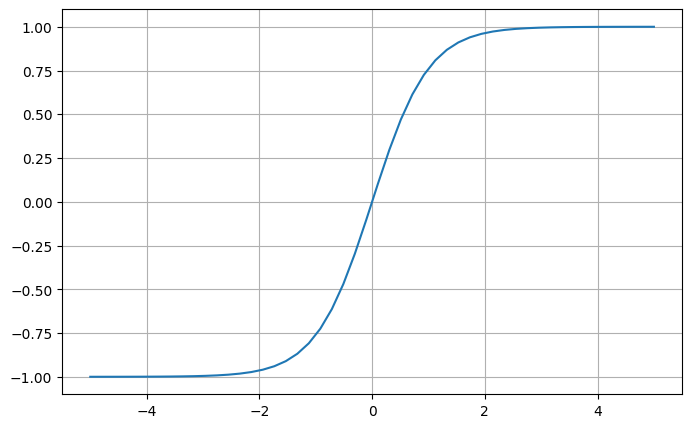

In [15]:
# tanh function in Python
x = np.linspace(-5, 5, 50)
z = np.tanh(x)

plt.subplots(figsize=(8, 5))
plt.plot(x, z)
plt.grid()
plt.show()

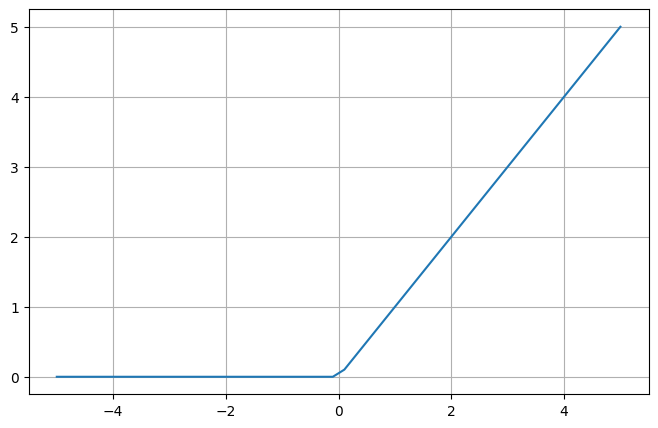

In [16]:
# ReLU in Python
x = np.linspace(-5, 5, 50)
z = [max(0, i) for i in x]

plt.subplots(figsize=(8, 5))
plt.plot(x, z)
plt.grid()
plt.show()

In [77]:
# Create a dataset with 10,000 samples.
X, y = make_circles(n_samples = 10000,
                    noise= 0.05,
                    random_state=26)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)

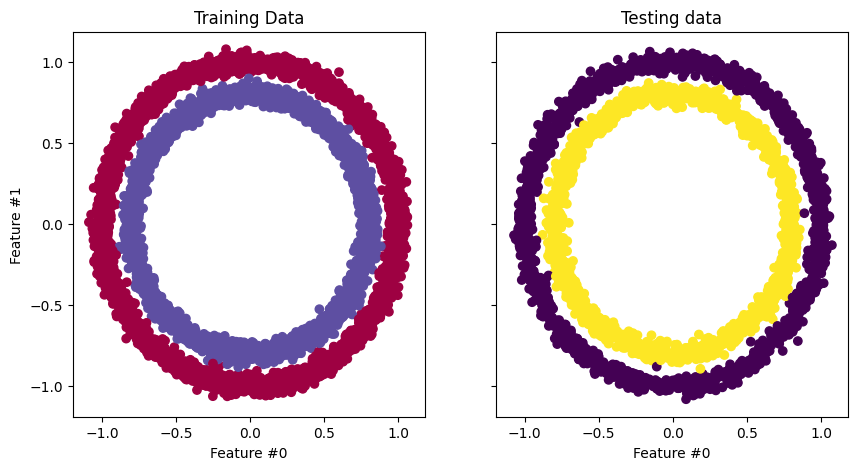

In [78]:
# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()

In [54]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [55]:
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [56]:
# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    break


# """
# Batch: 1
# X shape: torch.Size([64, 2])
# y shape: torch.Size([64])
# """

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


In [57]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.sigmoid(self.layer_2(x))

        return x

In [58]:
input_dim = 2
hidden_dim = 10
output_dim = 1
    
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)


# """
# NeuralNetwork(
#   (layer_1): Linear(in_features=2, out_features=10, bias=True)
#   (layer_2): Linear(in_features=10, out_features=1, bias=True)
# )
# """

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


In [59]:
learning_rate = 0.1

loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [60]:
num_epochs = 100
loss_values = []


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


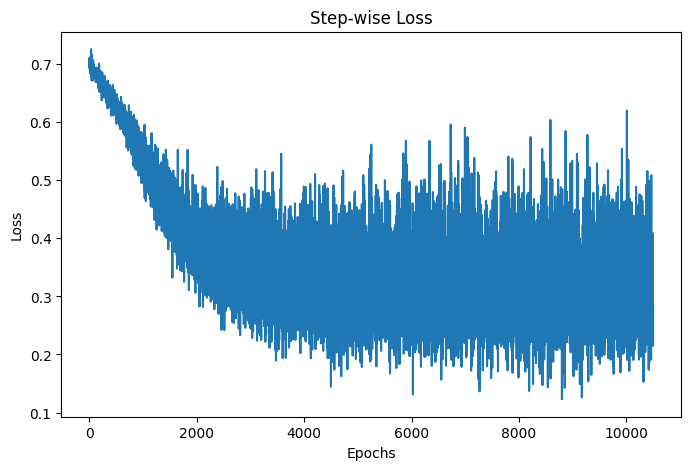

In [61]:
step = range(len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [62]:
# Initialize required variables
y_pred = []
y_test = []
correct = 0
total = 0

# We're not training so we don't need to calculate the gradients for our outputs

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)  # Get model outputs
        predicted = np.where(outputs.numpy() < 0.5, 0, 1)  # Convert to NumPy and apply threshold
        predicted = list(itertools.chain(*predicted))  # Flatten predictions
        y_pred.append(predicted)  # Append predictions
        y_test.append(y.numpy())  # Append true labels as NumPy
        total += y.size(0)  # Increment total count
        correct += (predicted == y.numpy()).sum().item()  # Count correct predictions

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')


Accuracy of the network on the 3300 test instances: 86%


In [63]:
y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86      1635
         1.0       0.86      0.89      0.87      1665

    accuracy                           0.87      3300
   macro avg       0.87      0.87      0.87      3300
weighted avg       0.87      0.87      0.87      3300



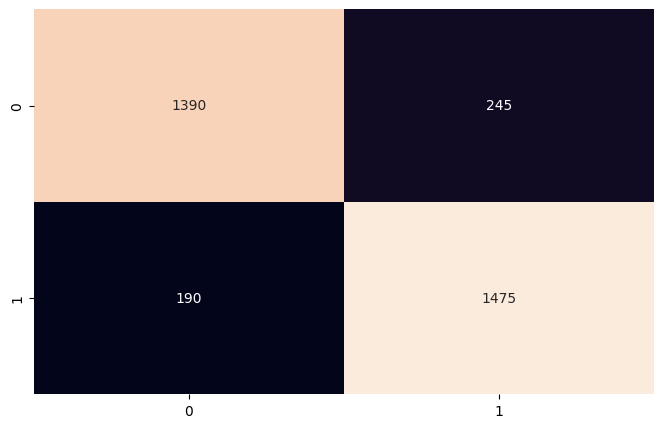

In [64]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()